# SDE models
The following notebook contains the code that was used to produce all plots in the report for the SDE chapter.

Note that all previous cells must be executed for the code to work.

For reference: the full notebook took about 30 seconds to run on my local machine.

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

## Figure 3.1

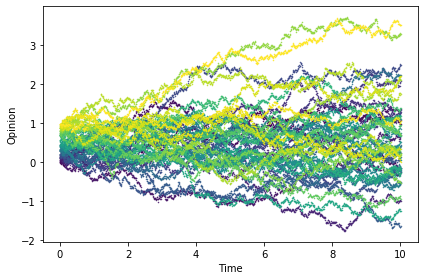

In [2]:
# display no periodic BC
def add_col(M):
    if len(M.shape) >1:
        M_new = np.zeros([M.shape[0], M.shape[1]+1])
        M_new[:, :-1] = M
    else:
        M_new = np.zeros(M.shape[0]+1)
        M_new[:-1] = M
    return M_new

def dynamics(x_0, e_l, e_r, t_end, h, s):
    agents = x_0.shape[0]
    one_over_agents_squared = 1/(agents**2)
    sqrth = np.sqrt(h)
    e_tot = e_l + e_r
    def dx_dt(x):
        x_prime = np.zeros(agents)
        row_matrix = np.tile(x, (agents,1))
        col_matrix = row_matrix.transpose()
        dist_matrix = row_matrix - col_matrix
        tf_1 = dist_matrix <= e_r
        tf_2 = dist_matrix >= -e_l
        considered = np.logical_and(tf_1, tf_2)
        considered_indicator = np.ma.masked_where(~considered, np.ones([agents, agents])).filled(0)
        considered_dist = np.ma.masked_where(~considered, dist_matrix)
        x_prime = np.sum(considered_dist, axis = 1)
        Q = one_over_agents_squared * np.sum(considered_indicator)
        return x_prime, Q                                                 # times 1/N ???
    
    
    t = 0
    i = 0
    k = 0
    Qs = []
    ts = [0]
    result = np.zeros([agents,1])
    result[:,0] = x_0
    while t < t_end:
        if i>200 and abs(Qs[i-150] - Qs[i-1]) < 10**(-3):
            k +=1
            if k >= 100:
                break
        t +=h
        ts.append(t)
        i +=1
        result = add_col(result)
        x_n = result[:,-2]
        function_value = dx_dt(x_n)
        dxdt = function_value[0]
        Q = function_value[1]
        Qs.append(Q)
        x_np1 = x_n + h*dxdt + s*sqrth*np.random.randn(agents)  # do one Euler step
        #result[:,-1] = np.mod(x_np1,1)                          # account for periodicity
        result[:,-1] = x_np1
    return result, Qs, ts

def display_dyn(x_0, e_l, e_r, t_end, h, s):
    agents = x_0.shape[0]
    results = dynamics(x_0, e_l, e_r, t_end, h, s)
    result = results[0]
    Qs = results[1]
    ts = results[2]
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, agents)]
    for a in range(agents):
        plt.plot(ts, result[a, :], ".", color = colors[a], markersize=1)

np.random.seed(1)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.1
e_r = 0.1
t_end = 10
h = 0.01
s = 0.3

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)

display_dyn(x_0, e_l, e_r, t_end, h, s)
plt.xlabel("Time")
plt.ylabel("Opinion")
plt.tight_layout()

## Figure 3.3

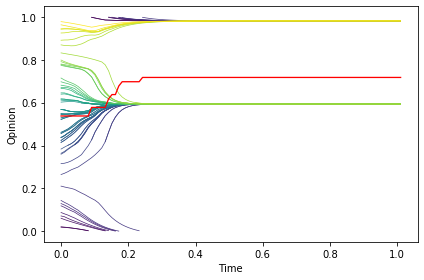

In [3]:
def dynamics(x_0, e_l, e_r, t_end, h, s, enforce_t_end = False):
    agents = x_0.shape[0]
    ones = np.ones([agents, agents])
    one_over_agents_squared = 1/(agents**2)
    sqrth = np.sqrt(h)
    e_tot = e_l + e_r
    def dx_dt(x):
        x_prime = np.zeros(agents)
        row_matrix = np.tile(x, (agents,1))
        col_matrix = row_matrix.transpose()
        dist_matrix = row_matrix - col_matrix
        dec_1 = dist_matrix < e_r - 1
        dec_2 = np.logical_and(dist_matrix <= 0, dist_matrix > - e_l)
        dec_3 = np.logical_and(dist_matrix >= 0, dist_matrix < e_r)
        dec_4 = dist_matrix > 1 - e_l
        considered_dist1 = np.ma.masked_where(~dec_1, dist_matrix + ones).filled(0)
        cons = np.logical_or(dec_2, dec_3)
        considered_dist23 = np.ma.masked_where(~cons, dist_matrix).filled(0)
        considered_dist4 = np.ma.masked_where(~dec_4, dist_matrix - ones).filled(0)
        
        considered = np.logical_or(cons, np.logical_or(dec_1, dec_4))
        considered_indicator = np.ma.masked_where(~considered, ones).filled(0)
        #considered_dist = np.ma.masked_where(~considered, dist_matrix)
        considered_dist = considered_dist1 + considered_dist23 + considered_dist4
        x_prime = np.sum(considered_dist, axis = 1)
        Q = one_over_agents_squared * np.sum(considered_indicator)
        return x_prime, Q                                                   # times 1/N ???
    
    
    t = 0
    i = 0
    k = 0
    Qs = []
    result = np.zeros([agents,1])
    result[:,0] = x_0
    di = 0
    while t < t_end:
        
        if not enforce_t_end:
            if i>200 and abs(Qs[i-150] - Qs[i-1]) < 0.001:
                k += 1
                if k >= 150:
                    break 
        t +=h
        i +=1
        result = add_col(result)
        x_n = result[:,-2]
        function_value = dx_dt(x_n)
        dxdt = function_value[0]
        Q = function_value[1]
        Qs.append(Q)
        x_np1 = x_n + h*dxdt + s*sqrth*np.random.randn(agents)  # do one Euler step
        result[:,-1] = np.mod(x_np1,1)                          # account for periodicity
    return result, Qs
    
def display_result(results, h, e_l, e_r, what, style="dot"):
    agents = results[0].shape[0]
    timesteps = results[0].shape[1]
    ts = np.linspace(0, h*timesteps, timesteps)
    result = results[0]
    Qs = results[1]
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, agents)]
    if what == "Q":
        plt.plot(ts[:-1], Qs)
        plt.plot(ts[:-1], (e_l + e_r)* np.ones(len(Qs)))
        plt.ylabel("Order parameter")
        plt.xlabel("Time")
    elif what == "dyn":
        if style == "line":
            for a in range(agents):
                to_plot = result[a,:]
                upper = to_plot >= 0.4
                lower = to_plot < 0.6
                h = np.ma.masked_where(~upper, to_plot)
                g = np.ma.masked_where(~lower, to_plot)
                plt.plot(ts, g, color = colors[a], linewidth=0.7)
                plt.plot(ts, h, color = colors[a], linewidth=0.7)
        else:
            for a in range(agents):
                plt.plot(ts, result[a,:], ".", color = colors[a], markersize=1)
        
        plt.ylabel("Opinion")
        plt.xlabel("Time")

np.random.seed(0)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.2
e_r = 0.2
t_end=1
h=0.01
s= 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn", "line")
timesteps = res[0].shape[1]
ts = np.linspace(0, h*timesteps, timesteps)
mean = np.mean(res[0], axis=0)
plt.plot(ts, mean, "r-", linewidth=1.3)
plt.xlabel("Time")
plt.ylabel("Opinion")

plt.tight_layout()
plt.show()

## Figure 3.4

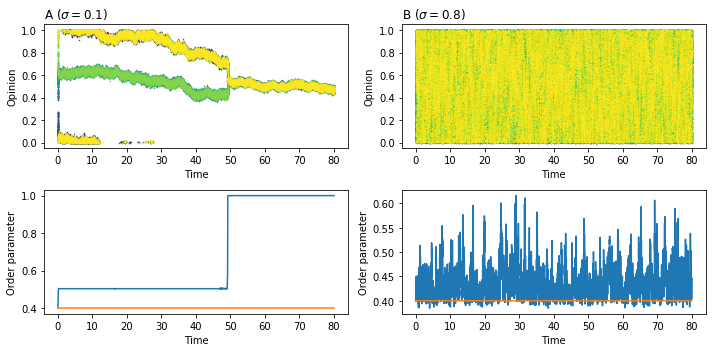

In [4]:
np.random.seed(4)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.2
e_r = 0.2
t_end = 80
h = 0.01

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,5)

plt.sca(ax[0,0])
s = 0.1
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn")
plt.title("A ($\sigma = 0.1$)" , loc="left")
plt.sca(ax[1,0])
display_result(res, h, e_l, e_r, "Q")


plt.sca(ax[0,1])
s = 0.8
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn")
plt.title("B ($\sigma = 0.8$)", loc="left")
plt.sca(ax[1,1])
display_result(res, h, e_l, e_r, "Q")

plt.tight_layout()

## Figure 3.5
The cell below must be run with `start = 0` and `end = 5` in order to obtain the `orderParameter_Sym_0005.csv` file. By going in increments of 5 (i.e. the next is `start = 5`, `end=10`) will give the full set of `.csv` files that are stored in the `savedResults/SDE` directory. The 10 files are then used to obtain the grid plot that is plotted in the second cell.

In [5]:
def cluster_analysis(x_0, e_l, e_r, t_end, h, s):
    return dynamics(x_0, e_l, e_r, t_end, h, s)[1][-1]

e_range = [0.001,0.5]
s_range = [0.001,0.5]
t_end = 100
h = 0.01
N = 50
start = 0
end = 5
sample = end

# count_grids = []
# for k in range(start, sample):
#     clear_output(wait=True)
#     #print("progress: ", k, " out of ", sample)
#     np.random.seed(k)
#     x_0 = np.sort(np.random.uniform(0,1,50))
#     grid_count = np.zeros([N, N])
#     es = np.linspace(e_range[0], e_range[1], N)
#     ss = np.linspace(s_range[0], s_range[1], N)
# 
#     for i in range(N):
#         e = es[i]
#         e_l = e
#         e_r = e
#         for j in range(N):
#             clear_output(wait=True)
#             print("sample  :", k, "out of", sample)
#             print("e       :", i, "out of", N)
#             print("s       :", j, "out of", N)
#             s = ss[j]
#             grid_count[i,j] = cluster_analysis(x_0, e_l, e_r, t_end, h, s)
#     count_grids.append(grid_count)
#     
#     
#     
# countgrid_final = np.mean(count_grids, axis =0)
# 
# if start < 10:
#     st = "0" + str(start)
# else:
#     st = str(start)  
# if end < 10:
#     en = "0" + str(end)
# else:
#     en = str(end)
# 
# np.savetxt('./savedResults/SDE/orderParameter_Sym_'+st+en+'.csv', countgrid_final, delimiter=';')

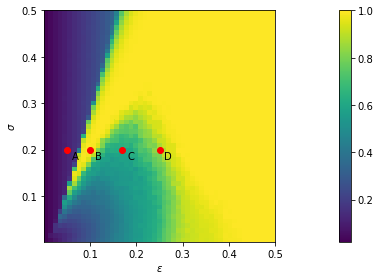

In [6]:
def plot_grid(i_values, j_values, matrix, i_values_label, j_values_label):
    mss, ess = np.meshgrid(j_values, i_values)
    plt.pcolormesh(ess, mss, matrix, cmap="viridis")
    plt.colorbar()
    plt.xlabel(i_values_label)
    plt.ylabel(j_values_label)
    
def make_marker(x, y, text, c):
    plt.plot(x, y, color = c, marker="o")
    plt.annotate(s = text, xy = (x,y), xytext = (x+0.01, y-0.02))
    return x
    

e_range = [0.001,0.5]
s_range = [0.001,0.5]
t_end = 100
h = 0.01
N = 50
es = np.linspace(e_range[0], e_range[1], N)
ss = np.linspace(s_range[0], s_range[1], N)

lab = ['0005', '0510', '1015', '1520', '2025', '2530', '3035', '3540', '4045', '4550',
       '5055', '5560', '6065', '6570', '7075', '7580', '8085', '8590', '9095', '95100']

data = []
for l in lab:
    data.append(np.genfromtxt('./savedResults/SDE/orderParameter/Sym_' + l + '.csv', delimiter=';'))
    
countgrid = np.mean(data, axis =0)

plot_grid(es, ss, countgrid, "$\epsilon$", "$\sigma$")
make_marker(0.05, 0.2, "A", "red")
make_marker(0.1, 0.2, "B", "red")
make_marker(0.17, 0.2, "C", "red")
make_marker(0.25, 0.2, "D", "red")

plt.axis('square')
plt.tight_layout()

## Figure 3.6

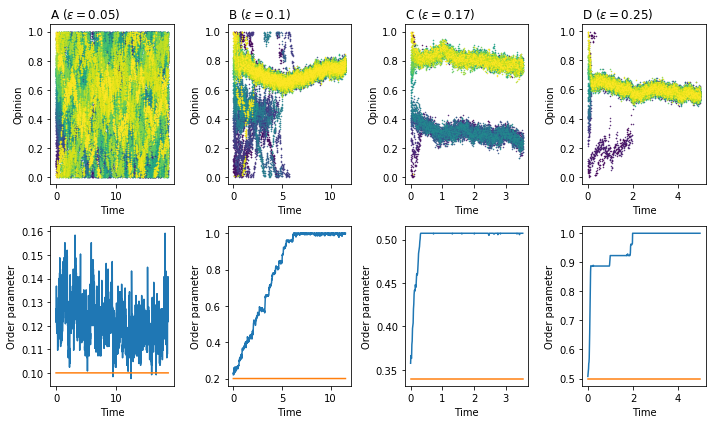

In [7]:
np.random.seed(6)
x_0 = np.sort(np.random.uniform(0,1,50))
t_end = 40
h = 0.01

fig, ax = plt.subplots(2, 4)
fig.set_size_inches(10, 6)

plt.sca(ax[0,0])
s = 0.2
e_l = 0.05
e_r = e_l
res = dynamics(x_0, e_l, e_r, t_end, h, s)
display_result(res, h, e_l, e_r, "dyn")
plt.title("A ($\epsilon = 0.05$)" , loc="left")
plt.sca(ax[1,0])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,1])
s = 0.2
e_l = 0.1
e_r = e_l
res = dynamics(x_0, e_l, e_r, t_end, h, s)
display_result(res, h, e_l, e_r, "dyn")
plt.title("B ($\epsilon = 0.1$)", loc="left")
plt.sca(ax[1,1])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,2])
s = 0.2
e_l = 0.17
e_r = e_l
res = dynamics(x_0, e_l, e_r, t_end, h, s)
display_result(res, h, e_l, e_r, "dyn")
plt.title("C ($\epsilon = 0.17$)" , loc="left")
plt.sca(ax[1,2])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,3])
s = 0.2
e_l = 0.25
e_r = e_l
res = dynamics(x_0, e_l, e_r, t_end, h, s)
display_result(res, h, e_l, e_r, "dyn")
plt.title("D ($\epsilon = 0.25$)", loc="left")
plt.sca(ax[1,3])
display_result(res, h, e_l, e_r, "Q")
plt.tight_layout()

## Figure 3.8

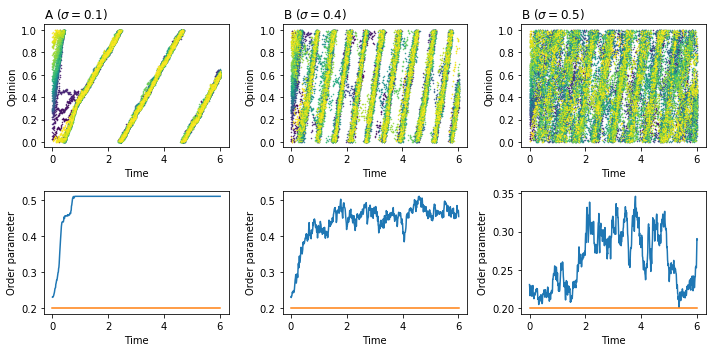

In [8]:
np.random.seed(3)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.0
e_r = 0.2
t_end = 6
h = 0.01

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 5)

plt.sca(ax[0,0])
s = 0.1
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
timesteps = res[0].shape[1]
ts = np.linspace(0, h*timesteps, timesteps)
display_result(res, h, e_l, e_r, "dyn")
plt.title("A ($\sigma = $"+ str(s) +")" , loc="left")
plt.sca(ax[1,0])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,1])
s = 0.4
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn")
mean = np.mean(res[0], axis=0)
plt.title("B ($\sigma = $"+ str(s) +")" , loc="left")
plt.sca(ax[1,1])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,2])
s = 0.5
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn")
mean = np.mean(res[0], axis=0)
plt.title("B ($\sigma = $"+ str(s) +")" , loc="left")
plt.sca(ax[1,2])
display_result(res, h, e_l, e_r, "Q")
plt.tight_layout()

## Figure 3.9

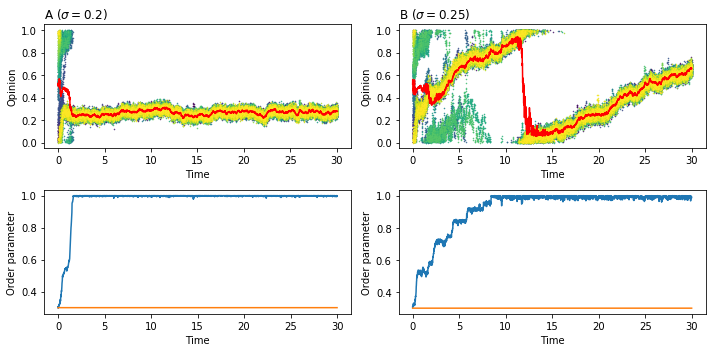

In [9]:
np.random.seed(4)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.1
e_r = 0.2
t_end = 30
h = 0.01

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 5)

plt.sca(ax[0,0])
s = 0.2
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
mean = np.mean(res[0], axis=0)
timesteps = res[0].shape[1]
ts = np.linspace(0, h*timesteps, timesteps)
display_result(res, h, e_l, e_r, "dyn")
plt.plot(ts, mean, "r-")
plt.title("A ($\sigma = $"+ str(s) +")" , loc="left")
plt.sca(ax[1,0])
display_result(res, h, e_l, e_r, "Q")

plt.sca(ax[0,1])
s = 0.25
res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
display_result(res, h, e_l, e_r, "dyn")
mean = np.mean(res[0], axis=0)
plt.plot(ts, mean, "r-")
plt.title("B ($\sigma = $"+ str(s) +")" , loc="left")
plt.sca(ax[1,1])
display_result(res, h, e_l, e_r, "Q")
plt.tight_layout()

## Figure 3.10
In order to obtain the data which is plotted in the second cell, we must run the cell below for the following pairs of $(\varepsilon_\ell, \varepsilon_r)$: 
- fix $\varepsilon_r = 0.1$ and take $\varepsilon_\ell \in \{0.0, 0.05, 0.1, 0.2, 0.3\}$
- fix $\varepsilon_r = 0.2$ and take $\varepsilon_\ell \in \{0.0, 0.05, 0.1, 0.2, 0.3\}$

The code result is stored in appropriate `.csv` files. Hence, the code is commented out in the first cell, and the corresponding `.csv` files are used in the second cell.

In [10]:
def count_peaks(res):
    mean = np.mean(res[0], axis = 0)
    maxima = argrelextrema(mean, np.greater, order = 40)
    minima = argrelextrema(mean, np.less, order = 40)
    k = 0
    for i in range(maxima[0].shape[0] - 1):
        maxi = maxima[0][i]
        for j in range(minima[0].shape[0]):
            mini = minima[0][j]
            if mini > maxi:
                if mean[maxi] - mean[mini] > 0.6:
                    k += 1
                break
    return k
N = 50
samples = 100
agents = 50
t_end = 30
e_l = 0.0
e_r = 0.1
h = 0.01
ss = np.linspace(0.001, 0.4, N)

peaks_array = np.zeros([samples, N])

# for i in range(samples):
#     clear_output(wait=True)
#     print(i, " out of ", samples)
#     np.random.seed(i)
#     x_0 = np.sort(np.random.uniform(0,1,agents))
#     for j in range(N):
#         clear_output(wait=True)
#         print(i, " out of ", samples)
#         print(j, " out of ", N)
#         s = ss[j]
#         res = dynamics(x_0, e_l, e_r, t_end, h, s, True)
#         peaks_array[i, j] = count_peaks(res)/t_end
# 
# peaks = np.mean(peaks_array, axis = 0)
# erStr = str(e_r).replace('.', '')
# elStr = str(e_l).replace('.', '')
# np.savetxt('./savedResults/SDE/peaksPerTime/el' + elStr + 'er' + erStr + '.csv', peaks, delimiter=';')

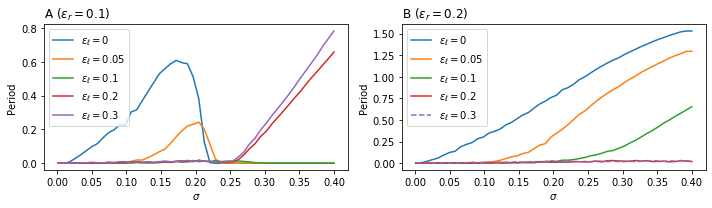

In [11]:
#number peeks
ss = np.linspace(0.001, 0.4, 50)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,3)

plt.sca(ax[0])
a = np.genfromtxt('./savedResults/SDE/peaksPerTime/el00er01.csv', delimiter=';')
b = np.genfromtxt('./savedResults/SDE/peaksPerTime/el005er01.csv', delimiter=';')
c = np.genfromtxt('./savedResults/SDE/peaksPerTime/el01er01.csv', delimiter=';')
d = np.genfromtxt('./savedResults/SDE/peaksPerTime/el02er01.csv', delimiter=';')
e = np.genfromtxt('./savedResults/SDE/peaksPerTime/el03er01.csv', delimiter=';')
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

plt.plot(ss, a, label="$\epsilon_\ell = 0$")
plt.plot(ss, b, label="$\epsilon_\ell = 0.05$")
plt.plot(ss, c, label="$\epsilon_\ell = 0.1$")
plt.plot(ss, d, label="$\epsilon_\ell = 0.2$")
plt.plot(ss, e, label="$\epsilon_\ell = 0.3$")
plt.xlabel("$\sigma$")
plt.ylabel("Period")
plt.title("A ($\epsilon_r = 0.1$)", loc="left")
plt.legend()


plt.sca(ax[1])
a = np.genfromtxt('./savedResults/SDE/peaksPerTime/el00er02.csv', delimiter=';')
b = np.genfromtxt('./savedResults/SDE/peaksPerTime/el005er02.csv', delimiter=';')
c = np.genfromtxt('./savedResults/SDE/peaksPerTime/el01er02.csv', delimiter=';')
d = np.genfromtxt('./savedResults/SDE/peaksPerTime/el02er02.csv', delimiter=';')
e = np.genfromtxt('./savedResults/SDE/peaksPerTime/el03er02.csv', delimiter=';')
plt.plot(ss, a, label="$\epsilon_\ell = 0$")
plt.plot(ss, b, label="$\epsilon_\ell = 0.05$")
plt.plot(ss, c, label="$\epsilon_\ell = 0.1$")
plt.plot(ss, d, label="$\epsilon_\ell = 0.2$")
plt.plot(ss, e, label="$\epsilon_\ell = 0.3$", linestyle = "--")
plt.xlabel("$\sigma$")
plt.ylabel("Period")
plt.title("B ($\epsilon_r = 0.2$)", loc="left")
plt.legend()

plt.tight_layout()